# Data & Library

In [1]:
from __future__ import print_function
# import argparse

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models
from torch.utils.data import Dataset

from PIL import Image 

In [2]:
data = pd.read_csv('/content/drive/MyDrive/toy_project/data_list.csv')
data

,image,label
0,image_1.png,1
1,image_2.png,1
2,image_3.png,0
3,image_4.png,0
4,image_5.png,0
5,image_6.png,1


In [8]:
img2 = cv2.imread('/content/drive/MyDrive/toy_project/images/image_3.png')
print(img2.shape)

(1472, 2390, 3)


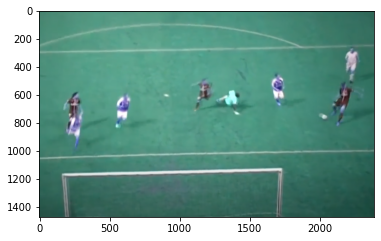

In [9]:
plt.imshow(img2)
plt.show()

# Define Dataset

In [3]:
def get_img(path):
    im_rgb = Image.open(path).convert('RGB')
    return im_rgb

class Fifadataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        
        self.output_label = output_label
        if self.output_label == True: 
            self.labels = self.df['label'].values

            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image']))

        if self.transforms:
            img = self.transforms(img)
        
        if self.output_label == True:
            return img, target
        else:
            return img

# Train model

In [16]:
def train(args, model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    class args:
        batch_size=128
        test_batch_size=1000
        epochs = 5
        lr = .1
        gamma = 0.1
        no_cuda = False
        dry_run = False
        seed = 1
        log_interval = 10
        save_model = False
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform_train=transforms.Compose([
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    dataset1 = Fifadataset(data, '/content/drive/MyDrive/toy_project/images', 
                 transforms=transform_train, 
                 output_label=True)
    dataset2 = Fifadataset(data, '/content/drive/MyDrive/toy_project/images', 
                 transforms=transform_train, 
                 output_label=True)

    train_loader = torch.utils.data.DataLoader(dataset1,**kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **kwargs)

    model = models.resnet50()
    model.fc = nn.Linear(2048, 2, bias=True)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

    scheduler = MultiStepLR(optimizer, milestones=[150, 250], gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, criterion, device, train_loader, optimizer, epoch)
        test(model, criterion, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


main()

Train Epoch: 1 [0/6 (0%)]	Loss: 0.684341

Test set: Average loss: 3114.7357, Accuracy: 3/6 (50%)

Train Epoch: 2 [0/6 (0%)]	Loss: 12.489181

Test set: Average loss: 1196174.1667, Accuracy: 3/6 (50%)

Train Epoch: 3 [0/6 (0%)]	Loss: 49.854870

Test set: Average loss: 174080768.0000, Accuracy: 3/6 (50%)

Train Epoch: 4 [0/6 (0%)]	Loss: 36.319035

Test set: Average loss: 13287934634.6667, Accuracy: 3/6 (50%)

Train Epoch: 5 [0/6 (0%)]	Loss: 56.740414

Test set: Average loss: 22302198442.6667, Accuracy: 3/6 (50%)

